In [1]:
# Enable if on M1/2 mac
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import src.halfar_ice as hi
from src.inference import run_inference
import torch
from torch import tensor as t
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import numpy as np

plt.rcParams.update({
    'font.family': 'Courier New',
    'font.size': 10,
    'figure.facecolor': 'lightgray',
    'axes.facecolor': 'lightgray',
})

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Simulation of Ice Dome

Iteration 00299/300


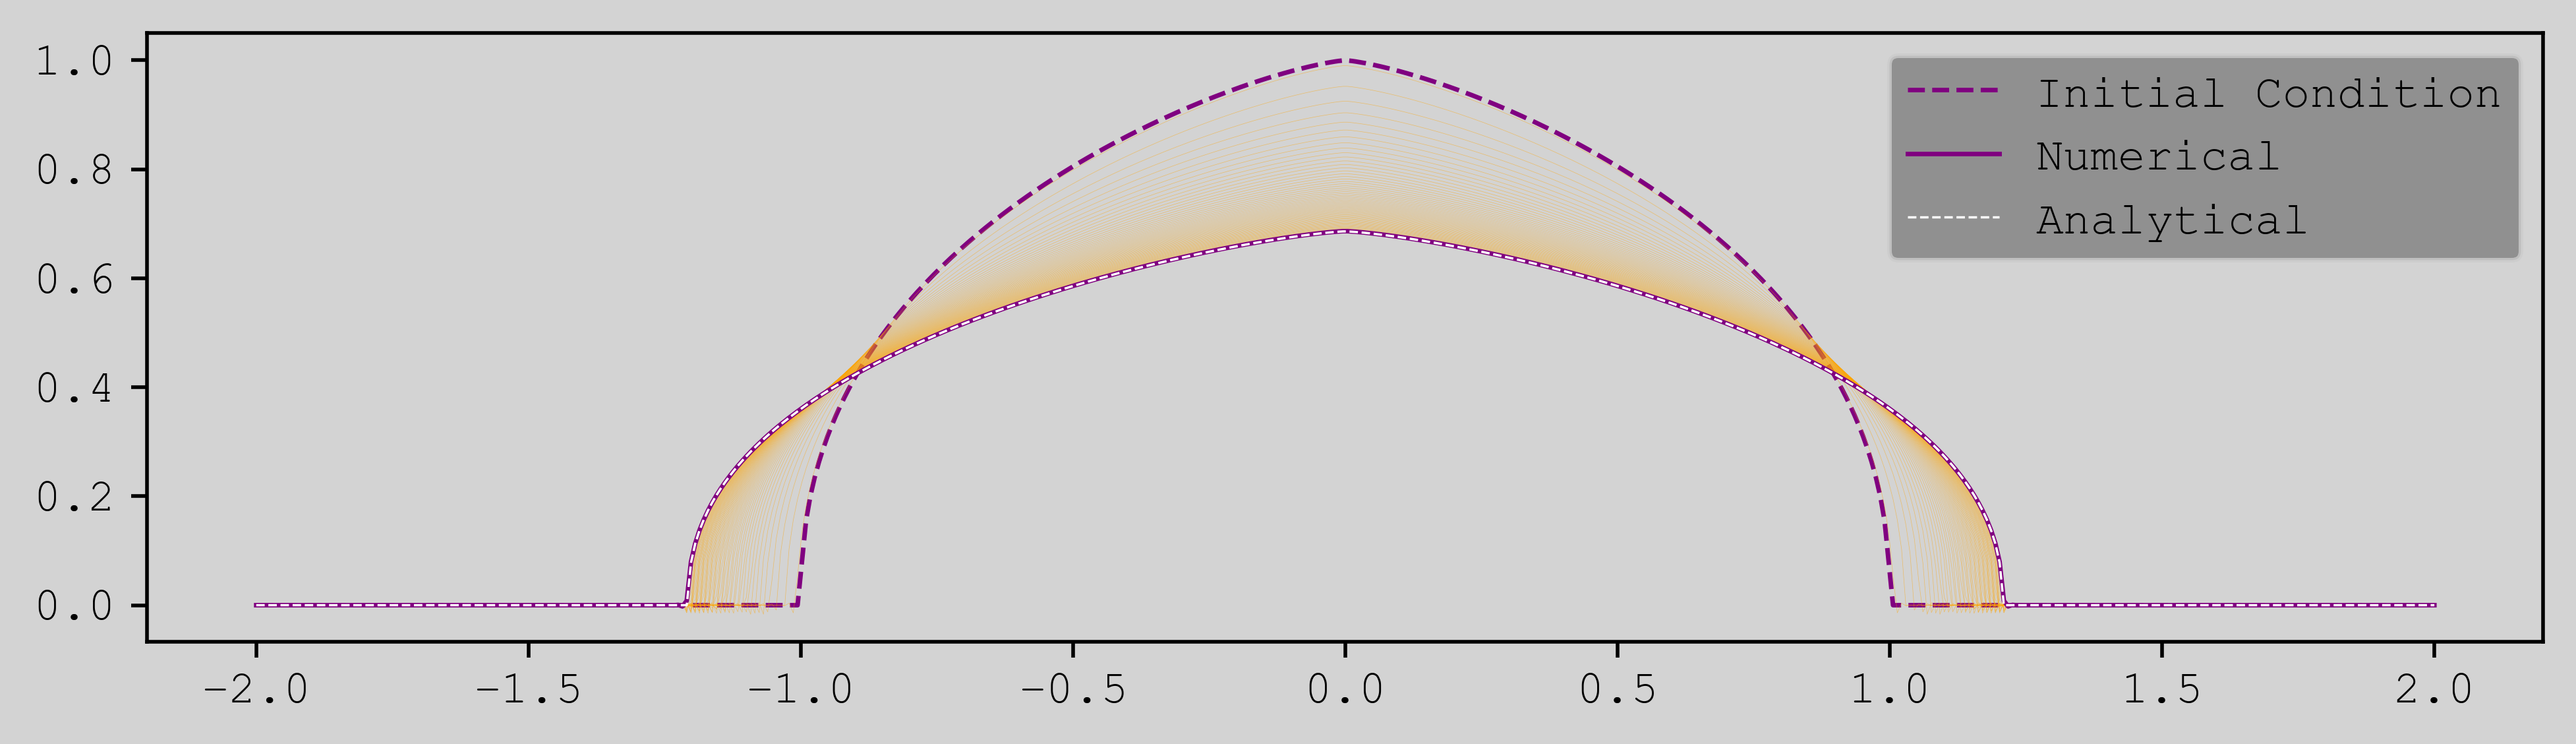

In [3]:
# Instantiate the numeric halfar ice model
num_hi_model = hi.HalfarIceNonLinearPolar(n_elements=511)

# Domain will be from -2. to 2. HalfarIceNonLinearPolar uses a lagrangian FE space of degree 1, meaning
#  our solutions will have n_elements + 1 points. x here is the radius of a radially symmetric dome of ice.
xx = torch.linspace(-2., 2., num_hi_model.n_elements + 1)

# Declare some ground truth parameters affecting flow and deformation rates.
true_ice_density = t(910.).double()
true_log_flow_rate = torch.log(t(1e-16)).double()

# The initial height and radius of the glacier in the standard dome shape.
h0, r0 = 1., 1.

# The gamma term is a constant affecting overall flow rates.
gamma = hi.stable_gamma(rho=true_ice_density, lA=true_log_flow_rate)

# The start time of the analytic solution, somewhat oddly, depends on the above parameters.
t0 = hi.t0f(r0, h0, gamma)

# Generate a halfar dome — with the above parameters — as the initial condition.
u_init = hi.halfar_ice_analytical(r=xx, t=t0, h0=h0, r0=r0, gamma=gamma)
# Massage into a shape expected by torch-fenics, and declare this as a leaf tensor for gradients.
u_init = u_init[None, :].double().clone().detach().requires_grad_(True)

# We'll employ a time stepping solution, so declare the initial condition as the last solution.
u_last_t = u_init

# Prepare a list of solutions vectors (one for each timestep).
sols = [u_last_t[0]]

# Our timestep is 1000...time units (years? days?)
tstep = t(1000).double()[None, None]

# Take 300 steps of 1000...time units.
num_steps = 300
for i in range(num_steps):
    print(f"\rIteration {i:05d}/{num_steps}", end='')

    # Execute the solver and append the solution to the list.
    u_last_t = num_hi_model(tstep, u_last_t, *torch.atleast_2d(true_ice_density, true_log_flow_rate))
    sols.append(u_last_t[0])
print()

fig, ax = plt.subplots(dpi=500, figsize=(8, 4))
hi.plot_sols(xx, sols, ax, skip=5, final_sol_lbl="Numerical")

# Compute the analytical solution at the end (absolute) time.
analytical_end_state = hi.halfar_ice_analytical(xx, t=t0 + num_steps * tstep.item(), h0=h0, r0=r0, gamma=gamma)

plt.plot(xx, analytical_end_state, color='white', linestyle='--',
         linewidth=0.5, label="Analytical")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend(facecolor='gray')
plt.show()

In [4]:
# As an aside, both the analytical and numeric solutions operate in polar coordinates, and thus their preservation of volume
#  (due to constant density and no flux boundary conditions) can only be seen when scaling by the radius.
print(f"Glacier Mass Before == c*{(xx.abs() * sols[0]).sum().item()}")
print(f"Glacier Mass After == c*{(xx.abs() * sols[-1]).sum().item()}")

Glacier Mass Before == c*80.31409517847527
Glacier Mass After == c*80.31409470434072


### Gradients

In [5]:
# Now, we check for proper gradients.
# Grab a point just the left of center.
poi_idx = num_hi_model.n_elements // 2 - 10

# Get gradients with respect to the final dome height at that point.
poi = sols[-1][poi_idx]
poi.backward()

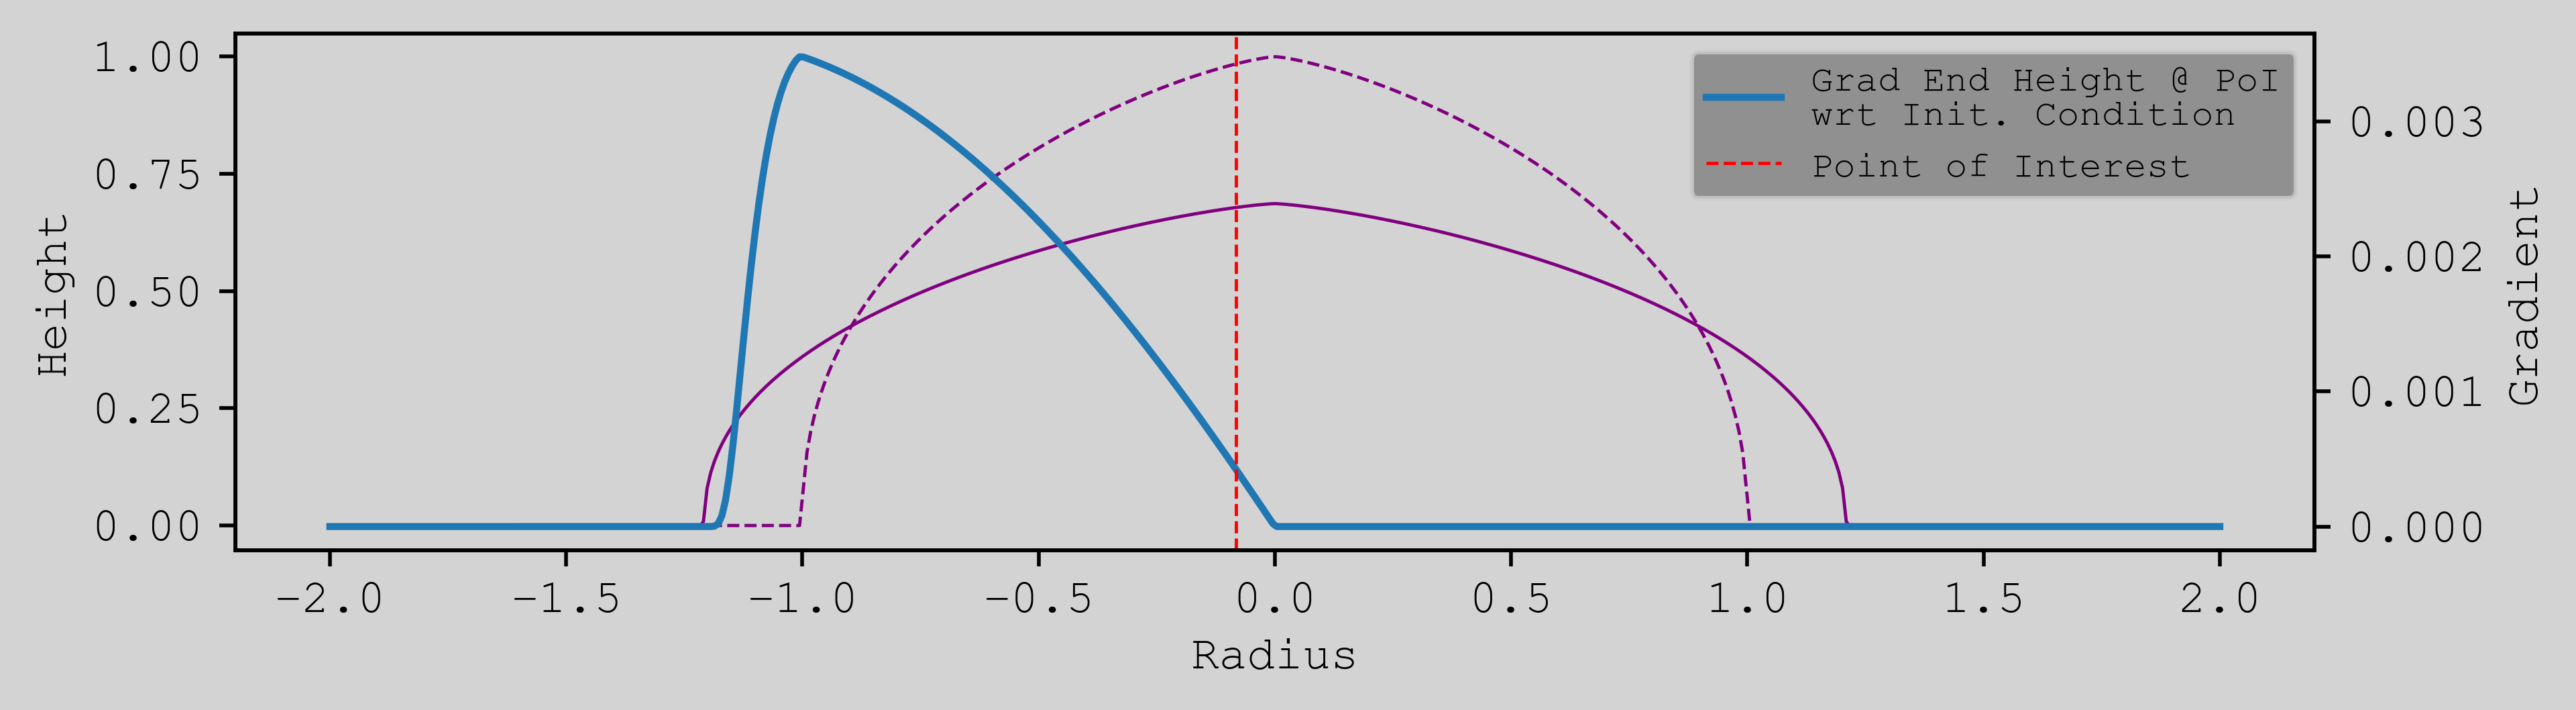

In [6]:
_, ax1 = plt.subplots(figsize=(8, 2), dpi=500)

ax1.plot(xx, u_init[0].detach(), color='purple', linestyle='--', linewidth=0.7)
ax1.plot(xx, sols[-1].detach(), color='purple', linewidth=0.7)
ax1.set_ylabel("Height")
ax1.set_xlabel("Radius")

ax2 = ax1.twinx()
ax2.plot(xx, u_init.grad[0].detach(), label='Grad End Height @ PoI\nwrt Init. Condition')
ax2.axvline(xx[poi_idx], color='red', linestyle='--', label='Point of Interest', linewidth=0.7)
ax2.set_ylabel("Gradient")
ax2.legend(facecolor='gray', fontsize=8)

### Measuring Glacier Depth

In [7]:
# Analytically simulate a glacier and noisily measure its depth at 10 separate times across 5 points on the left slope.
measurement_times = t([t0 + tstep.item() * i for i in range(0,50,5)]).double() + tstep.item() * 5
# We'll take measurements on the mesh. TODO figure out measurements that are not on the mesh/adapt the mesh to observations.
measurement_poi_idx = torch.linspace(130, 256, 5, dtype=torch.int64)
measurement_poi = xx[measurement_poi_idx]

# Generate the true depths.
true_depths = hi.halfar_ice_analytical(r=measurement_poi[None, :], t=measurement_times[:, None], h0=h0, r0=r0, gamma=gamma)

In [8]:
print(measurement_times[:, None].numpy().round())

[[15463.]
 [20463.]
 [25463.]
 [30463.]
 [35463.]
 [40463.]
 [45463.]
 [50463.]
 [55463.]
 [60463.]]


In [9]:
print(true_depths.numpy().round(3))

[[0.268 0.611 0.783 0.893 0.957]
 [0.298 0.602 0.763 0.867 0.928]
 [0.316 0.594 0.748 0.847 0.906]
 [0.328 0.588 0.735 0.831 0.888]
 [0.336 0.582 0.725 0.818 0.873]
 [0.342 0.578 0.716 0.807 0.86 ]
 [0.347 0.574 0.708 0.797 0.849]
 [0.351 0.57  0.701 0.788 0.839]
 [0.354 0.566 0.695 0.78  0.831]
 [0.357 0.563 0.689 0.773 0.823]]


##### Define a Measurement Noise Model in Pyro

In [10]:
def measurement_noise(true_depths_, noise_scale=0.05):
    return pyro.sample("measurements", dist.Normal(true_depths_, noise_scale).to_event(2))
measurements = measurement_noise(true_depths)

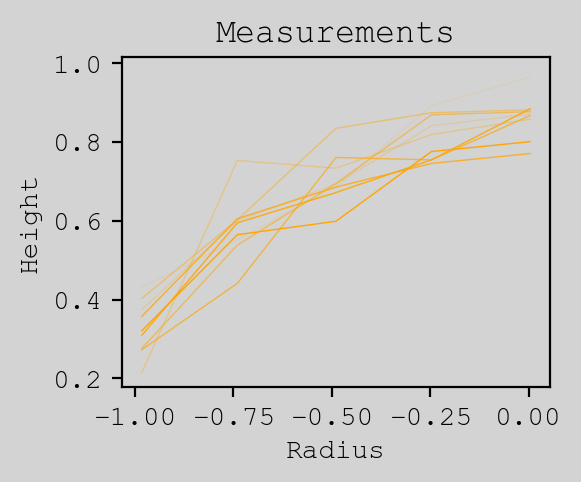

In [11]:
# Show measurements, in increasing opacity from oldest to newest.
_, ax = plt.subplots(dpi=200, figsize=(3, 3))
for i in range(measurements.shape[0]):
    alpha = i / (measurements.shape[0] - 1)
    ax.plot(measurement_poi, measurements[i, :], color='orange', linewidth=0.5, alpha=alpha)
ax.set_ylabel("Height")
ax.set_xlabel("Radius")
ax.set_title("Measurements")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

### Full Observational Model

In [12]:
DENSITY_RANGE = np.array((800, 940))
LOG_FLOW_RATE_RANGE = np.log(np.array((1e-24, 1e-15)))

# Define normal priors for the ice density and flow rate.
def prior():
    # return pyro.sample("ice_density", dist.Normal(DENSITY_RANGE.mean(), np.ptp(DENSITY_RANGE) / 3.)).double(), \
    #        pyro.sample("log_flow_rate", dist.Normal(LOG_FLOW_RATE_RANGE.mean(), np.ptp(LOG_FLOW_RATE_RANGE) / 3.)).double()
    return pyro.sample("ice_density", dist.Uniform(*DENSITY_RANGE)).double(), \
           pyro.sample("log_flow_rate", dist.Uniform(*LOG_FLOW_RATE_RANGE)).double()

In [13]:
# Define a model
# noinspection PyShadowingNames
def num_true_depth_model(t0, ts, u0, ice_density, log_flow_rate):
    """

    :param t0: The initial, absolute time of the initial condition. (scalar)
    :param ts: The absolute times at which to solve for the glacier's height. (vector)
    :param u0: The initial state of the mesh at t=0. (vector)
    :param ice_density: The density of the ice (rho). (scalar)
    :param log_flow_rate: The log of the flow rate (log(A)). (scalar)
    :return: The heights of the glacier at each time and measurement radius (with shape (len(ts), len(measurement_poi_idx))). (matrix)
    """

    true_depths = []

    # Initialize the iteratively updated solution.
    ul = u0

    tl = t0
    for t in ts:
        ul = num_hi_model(*torch.atleast_2d(t - tl, ul, ice_density, log_flow_rate))[0]
        tl = t

        # Append the solution at this time to the list.
        true_depths.append(ul[measurement_poi_idx])

    return torch.stack(true_depths)

In [14]:
# noinspection PyShadowingNames
def model():
    # Sample the ice density and flow rate from the prior.
    ice_density, log_flow_rate = prior()

    # Solve for the true depths at the measurement times.
    true_depths = num_true_depth_model(t0, measurement_times, u_init, ice_density, log_flow_rate)

    # Sample the measurements from the measurement noise model.
    return measurement_noise(true_depths)

### Inference

In [15]:
with pyro.condition(data={"measurements": measurements}):
    losses, guide = run_inference(
        model=model,
        prior=prior,
        steps=10000,
        verbose=True,
        verbose_every=10
    )

Step 0, loss 53.14578077950126
Step 10, loss 54.00914839588263
Step 20, loss 47.1132500462315
Step 30, loss 49.40291216968158
Step 40, loss 51.48824309564665
Step 50, loss 53.614681121248736
Step 60, loss 53.62124241142517
Step 70, loss 48.396382524094314
Step 80, loss 52.20553191500737
Step 90, loss 53.64306594758707
Step 100, loss 52.59139015160889


KeyboardInterrupt: 